In [1]:
%load_ext autoreload
%autoreload 2
from nbutils import chdir_to_root
chdir_to_root()
%pwd

'/home/tornikeo/Documents/work/scalexa/pangeaai/optimize-cosine'

In [2]:
from cudams.utils import argbatch, mkdir, \
    get_ref_spectra_from_df
from cudams.similarity.kernels import compile_cuda_cosine_greedy_kernel
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

assert cuda.is_available()

In [3]:
## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 512

# MAX NUMBER OF PEAKS 
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

In [4]:
# from cudams.similarity.processor import \
#     CudaCosineGreedy, CpuCosineGreedy
# from collections import defaultdict
# from matchms import calculate_scores
# from matchms.similarity import CosineGreedy
# from tqdm import tqdm
# from matchms.similarity import CosineGreedy
# from matchms.filtering import normalize_intensities, select_by_mz, select_by_relative_intensity, reduce_to_number_of_peaks, \
#     require_minimum_number_of_peaks
# from cudams.utils import mute_stdout

In [5]:
from matchms.filtering import reduce_to_number_of_peaks

def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
    return spectrum

ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=BATCH_SIZE,)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df, 
                                spectrum_processor=process_spectrum,
                                limit=BATCH_SIZE,)

100%|██████████| 512/512 [00:00<00:00, 3215.43it/s]


In [12]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores

# similarity_measure = CosineGreedy(
#     tolerance= 0.1, 
#     mz_power= 0.0, 
#     intensity_power = 1.0
# )
# mts_scores = calculate_scores(references, queries, similarity_measure, is_symmetric=True).to_array()
# mts_scores, mts_num_matches = mts_scores['CosineGreedy_score'], mts_scores['CosineGreedy_matches']
# mts_out = np.stack([mts_scores, mts_num_matches],axis=-1)

scores = calculate_scores(references=references,
                          queries=queries,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True).to_array()
print(f"Size of matrix of computed similarities: {scores.shape}")

Size of matrix of computed similarities: (512, 512)


In [13]:
from cudams.similarity import CudaCosineGreedy
from joblib import Parallel, delayed

def it(MATCH_LIMIT):
    scores = calculate_scores(
            references=references,
            queries=queries,
            is_symmetric=False,
            similarity_function=CudaCosineGreedy(match_limit=int(MATCH_LIMIT), batch_size=512)
        ).to_array()
    return scores

match_limits = np.linspace(128, 2048, 8, dtype=int)
scores_cu = Parallel(n_jobs=4)(
    delayed(it)(match_limit) for match_limit in tqdm(match_limits)
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


In [18]:
score_cu = scores_cu[0]['CudaCosineGreedy_']

In [50]:
x = []
y = []


score = scores['CosineGreedy_score']
matches = scores['CosineGreedy_matches']

R, Q = BATCH_SIZE, BATCH_SIZE
for match_limit, score_cu_ in zip(match_limits, scores_cu):
    
    score_cu = score_cu_['CudaCosineGreedy_score']
    matches_cu = score_cu_['CudaCosineGreedy_matches']
    overflow_cu = score_cu_['CudaCosineGreedy_overflow']
    y_row = []
    print('@ MATCH_LIMIT', match_limit)

    score_eq = np.isclose(score, score_cu)
    score_corr = score_eq.mean()
    print("mean(score_gpu == score_cpu):", score_corr)
    y_row.append(score_corr)
    
    matches_eq = np.isclose(matches, matches_cu)
    matches_corr = matches_eq.mean()
    print("mean(num_match_gpu == num_match_cpu):", matches_corr)
    y_row.append(matches_corr)

    overflow_mean = overflow_cu.mean()
    y_row.append(1 - overflow_mean)
    print("1 - mean(overflow)", 1 - overflow_mean)
    
    y.append(y_row)
    x.append(match_limit)

@ MATCH_LIMIT 128
mean(score_gpu == score_cpu): 0.9828872680664062
mean(num_match_gpu == num_match_cpu): 0.98284912109375
1 - mean(overflow) 0.9827919006347656
@ MATCH_LIMIT 402
mean(score_gpu == score_cpu): 0.9991569519042969
mean(num_match_gpu == num_match_cpu): 0.9991531372070312
1 - mean(overflow) 0.9991531372070312
@ MATCH_LIMIT 676
mean(score_gpu == score_cpu): 0.9998321533203125
mean(num_match_gpu == num_match_cpu): 0.99981689453125
1 - mean(overflow) 0.99981689453125
@ MATCH_LIMIT 950
mean(score_gpu == score_cpu): 0.9999465942382812
mean(num_match_gpu == num_match_cpu): 0.9999427795410156
1 - mean(overflow) 0.9999427795410156
@ MATCH_LIMIT 1225
mean(score_gpu == score_cpu): 0.9999618530273438
mean(num_match_gpu == num_match_cpu): 0.9999618530273438
1 - mean(overflow) 0.9999618530273438
@ MATCH_LIMIT 1499
mean(score_gpu == score_cpu): 0.9999656677246094
mean(num_match_gpu == num_match_cpu): 0.9999656677246094
1 - mean(overflow) 0.9999656677246094
@ MATCH_LIMIT 1773
mean(score_gp

Text(0.5, 0, 'MATCH_LIMIT')

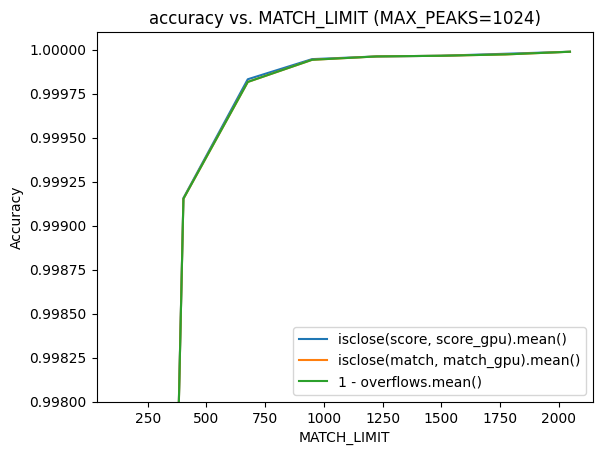

In [51]:
plt.plot(x,np.array(y))
plt.ylim([.998,1.0001])

plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['isclose(score, score_gpu).mean()',
            'isclose(match, match_gpu).mean()',
            "1 - mean(overflows)"])
plt.ylabel("Accuracy")
plt.xlabel("MATCH_LIMIT")

Text(0.5, 0, 'MATCH_LIMIT')

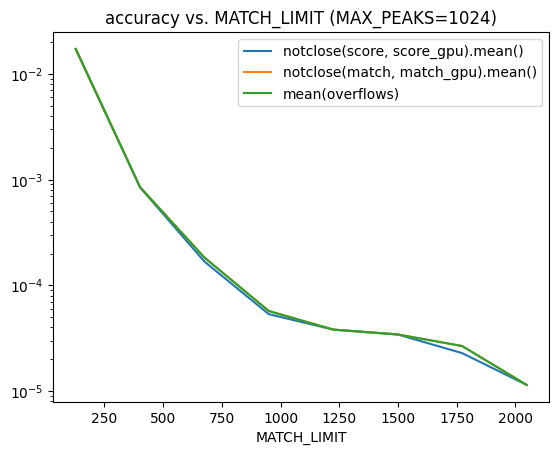

In [56]:
plt.semilogy(x, 1 - np.array(y))
plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['notclose(score, score_gpu).mean()',
            'notclose(match, match_gpu).mean()',
            "mean(overflows)"])
plt.xlabel("MATCH_LIMIT")